In [104]:
####################### BLOCK 1: IMPORTS AND UTILITIES #######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import os

def prepare_data(data, selected_features):
    
    if isinstance(data, pd.DataFrame):
        if isinstance(selected_features[0], str):
            X = data[selected_features].values
            feature_names = selected_features
        else:
            X = data.iloc[:, selected_features].values
            feature_names = data.columns[selected_features].tolist()
    else:
        X = data[:, selected_features]
        feature_names = [f"Feature {i}" for i in selected_features]
        
    return X, feature_names

def make_corner_plot(data, labels, plot_features, method_name, figsize=(12, 12)):
    n_features = len(plot_features)
    fig, axes = plt.subplots(n_features, n_features, figsize=figsize)
    
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    padding = 0.1
    
    for i in range(n_features):
        for j in range(n_features):
            ax = axes[i, j]
            
            if i < j:  # Upper triangle
                ax.set_visible(False)
                continue
                
            xmin = min(data[plot_features[j]]) - padding
            xmax = max(data[plot_features[j]]) + padding
            ymin = min(data[plot_features[i]]) - padding
            ymax = max(data[plot_features[i]]) + padding
                
            if i == j:  # Diagonal
                for label, color in zip(unique_labels, colors):
                    mask = labels == label
                    ax.hist(data[plot_features[i]][mask], bins=20, 
                           color=color, alpha=0.6, label=f'Cluster {label}')
                ax.set_xlim(xmin, xmax)
                ax.set_title(plot_features[i])
            else:  # Lower triangle
                for label, color in zip(unique_labels, colors):
                    mask = labels == label
                    ax.scatter(data[plot_features[j]][mask], 
                             data[plot_features[i]][mask],
                             c=[color], alpha=0.6, s=20, label=f'Cluster {label}')
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)
            
            # Labels
            if i == n_features-1:
                ax.set_xlabel(plot_features[j])
            if j == 0:
                ax.set_ylabel(plot_features[i])
                
            # Only show legend once in the first subplot
            if i == n_features-1 and j == 0:
                ax.legend(title="Clusters", bbox_to_anchor=(0.5, 0.5))

    # plt.suptitle(f'{method_name} Corner Plot', y=1.02)
    plt.tight_layout()
    return fig

def plot_multi_method_features(data, methods, features, figsize=(15, 10)):
    n_methods = len(methods)
    n_features = len(features)
    
    fig, axes = plt.subplots(n_methods, n_features, figsize=figsize)
    if n_methods == 1:
        axes = axes.reshape(1, -1)
    
    # Get colors for clusters
    max_clusters = max(len(np.unique(labels)) for labels in methods.values())
    colors = plt.cm.rainbow(np.linspace(0, 1, max_clusters))
    
    for row, (method_name, labels) in enumerate(methods.items()):
        unique_labels = np.unique(labels)
        
        for col, feature in enumerate(features):
            ax = axes[row, col]
            
            # Plot scatter for each cluster
            for label, color in zip(unique_labels, colors):
                mask = labels == label
                ax.scatter(data['DoR'][mask], data[feature][mask],
                          c=[color], alpha=0.6, label=f'Cluster {label}')
            
            ax.set_xlabel('DoR')
            ax.set_ylabel(feature)
            
            if col == 0:
                ax.set_title(f'{method_name}\n{feature} vs DoR')
            else:
                ax.set_title(f'{feature} vs DoR')            
            if row == 0 and col == 0:
                ax.legend(title="Clusters")
                
    plt.tight_layout()
    return fig

def relabel_by_dor_and_mgfe(labels, df):
        # Calculate mean metrics for each cluster
        cluster_stats = {}
        for label in np.unique(labels):
            mask = labels == label
            cluster_stats[label] = {
                'DoR': df[mask]['DoR'].mean(),
                'MgFe': df[mask]['MgFe'].mean(),
                'size': mask.sum()
            }
            print(f"\nOriginal Cluster {label}:")
            print(f"Mean DoR: {cluster_stats[label]['DoR']:.3f}")
            print(f"Mean MgFe: {cluster_stats[label]['MgFe']:.3f}")
            print(f"Size: {cluster_stats[label]['size']}")
        
        # Create mapping using both DoR and MgFe
        mapping = dict(enumerate(sorted(cluster_stats.keys(),
                                     key=lambda x: cluster_stats[x]['DoR'],
                                     reverse=True)))
        
        print("\nCluster Mapping:")
        for new_label, old_label in mapping.items():
            print(f"Old cluster {old_label} → New cluster {new_label}")
            
        return np.array([mapping[label] for label in labels])

def export_clustering_results(df, methods, output_path='../data/cluster_results'):
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    # Create SDSS identifiers
    sdss_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])]
    
    # Export results with relabeled clusters
    for method_name, labels in methods.items():
        print(f"\nRelabeling {method_name} clusters:")
        relabeled_labels = relabel_by_dor_and_mgfe(labels, df)
        results_df = pd.DataFrame({
            'SDSS_ID': sdss_ids,
            'Cluster': relabeled_labels
        })
        
        filename = os.path.join(output_path, f'{method_name.lower().replace(" ", "_")}_clusters.csv')
        results_df.to_csv(filename, index=False)
        print("Made files")


In [105]:
####################### BLOCK 2: K-MEANS #######################
def kmeans_clustering(data, selected_features, n_clusters=3):

    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)    

    
    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++', n_init=100) #or init = k-means++???
    labels = kmeans.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "K-Means Clustering")
    #plt.show()
    return kmeans, labels



In [106]:
def gmm_clustering(data, selected_features, n_components=3):
    X, feature_names = prepare_data(data, selected_features)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Try different covariance types
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    best_bic = np.inf
    best_gmm = None
    
    for cv_type in covariance_types:
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=cv_type,
            random_state=42,
            n_init=100,  # Increased from 10
            max_iter=300,  # Added max iterations
            reg_covar=1e-6,  # Added regularization
            init_params='kmeans'
        )
        gmm.fit(X_scaled)
        bic = gmm.bic(X_scaled)
        if bic < best_bic:
            best_bic = bic
            best_gmm = gmm
    
    labels = best_gmm.fit_predict(X_scaled)
    return best_gmm, labels    


In [107]:
####################### BLOCK 6: HIERARCHICAL #######################
def hierarchical_clustering(data, selected_features, n_clusters=3):
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Hierarchical Clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    labels = hc.fit_predict(X_scaled)
    
    # Plot results
    #plot_clusters(X, labels, feature_names, "Hierarchical Clustering")
    #plt.show()
    
    return hc, labels


def plot_dendrogram(data, selected_features, method='ward', figsize=(10,7)):

    # Prepare and scale data
    X, feature_names = prepare_data(data, selected_features)
    X_scaled = StandardScaler().fit_transform(X)
    
    # Calculate linkage matrix
    Z = linkage(X_scaled, method=method)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(Z)
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()
    
    return Z


# USAGE + PLOTTING


In [108]:
selected_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass'] #, 'logM*','meanRadkpc_r', 'Mtbb3', 't_75', 't_100']
plot_features = ['MgFe', 'age_mean_mass', '[M/H]_mean_mass', 'velDisp_ppxf_res'] 

df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
df = df.sample(frac=1).reset_index(drop=True)
dor_values = df['DoR'].values  # Get DoR separately for coloring

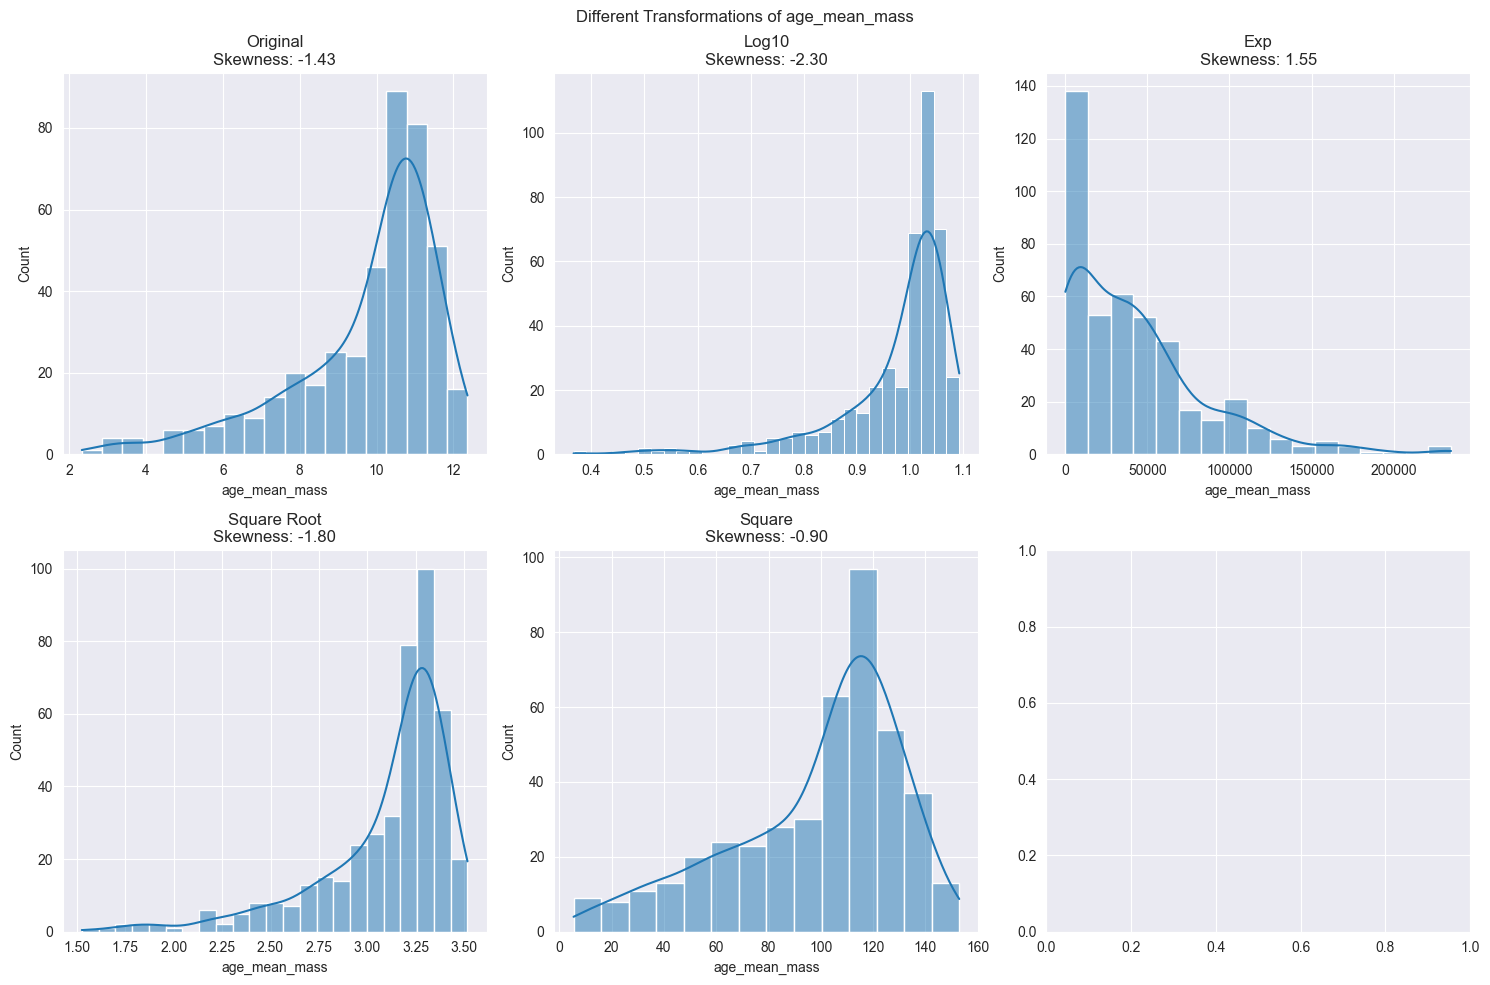

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Make a copy to test transformations
df_test = df.copy()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Different Transformations of age_mean_mass')

# Original
sns.histplot(df_test['age_mean_mass'], kde=True, ax=axs[0,0])
axs[0,0].set_title(f'Original\nSkewness: {stats.skew(df_test["age_mean_mass"]):.2f}')

# Log (what you tried)
sns.histplot(np.log10(df_test['age_mean_mass']), kde=True, ax=axs[0,1])
axs[0,1].set_title(f'Log10\nSkewness: {stats.skew(np.log10(df_test["age_mean_mass"])):.2f}')

# Exponential (what you suggested)
sns.histplot(np.exp(df_test['age_mean_mass']), kde=True, ax=axs[0,2])
axs[0,2].set_title(f'Exp\nSkewness: {stats.skew(np.exp(df_test["age_mean_mass"])):.2f}')

# Square root (often good for left-skewed data)
sns.histplot(np.sqrt(df_test['age_mean_mass']), kde=True, ax=axs[1,0])
axs[1,0].set_title(f'Square Root\nSkewness: {stats.skew(np.sqrt(df_test["age_mean_mass"])):.2f}')

# Square (another option)
sns.histplot(df_test['age_mean_mass']**2, kde=True, ax=axs[1,1])
axs[1,1].set_title(f'Square\nSkewness: {stats.skew(df_test["age_mean_mass"]**2):.2f}')

"""# Box-Cox transformation
transformed_data, lambda_param = stats.boxcox(df_test['age_mean_mass'])
sns.histplot(transformed_data, kde=True, ax=axs[1,2])
axs[1,2].set_title(f'Box-Cox\nSkewness: {stats.skew(transformed_data):.2f}\nλ={lambda_param:.2f}')
"""
plt.tight_layout()
plt.show()

In [110]:




#### LOG TRANSFORMATION OF STUFF
df=df.copy()
#df['age_mean_mass'] = np.log10(df['age_mean_mass'])
#df['age_mean_mass'] = np.sqrt((df['age_mean_mass']))
df['velDisp_ppxf_res'] = np.log10(df['velDisp_ppxf_res'])







METHOD: K-Means


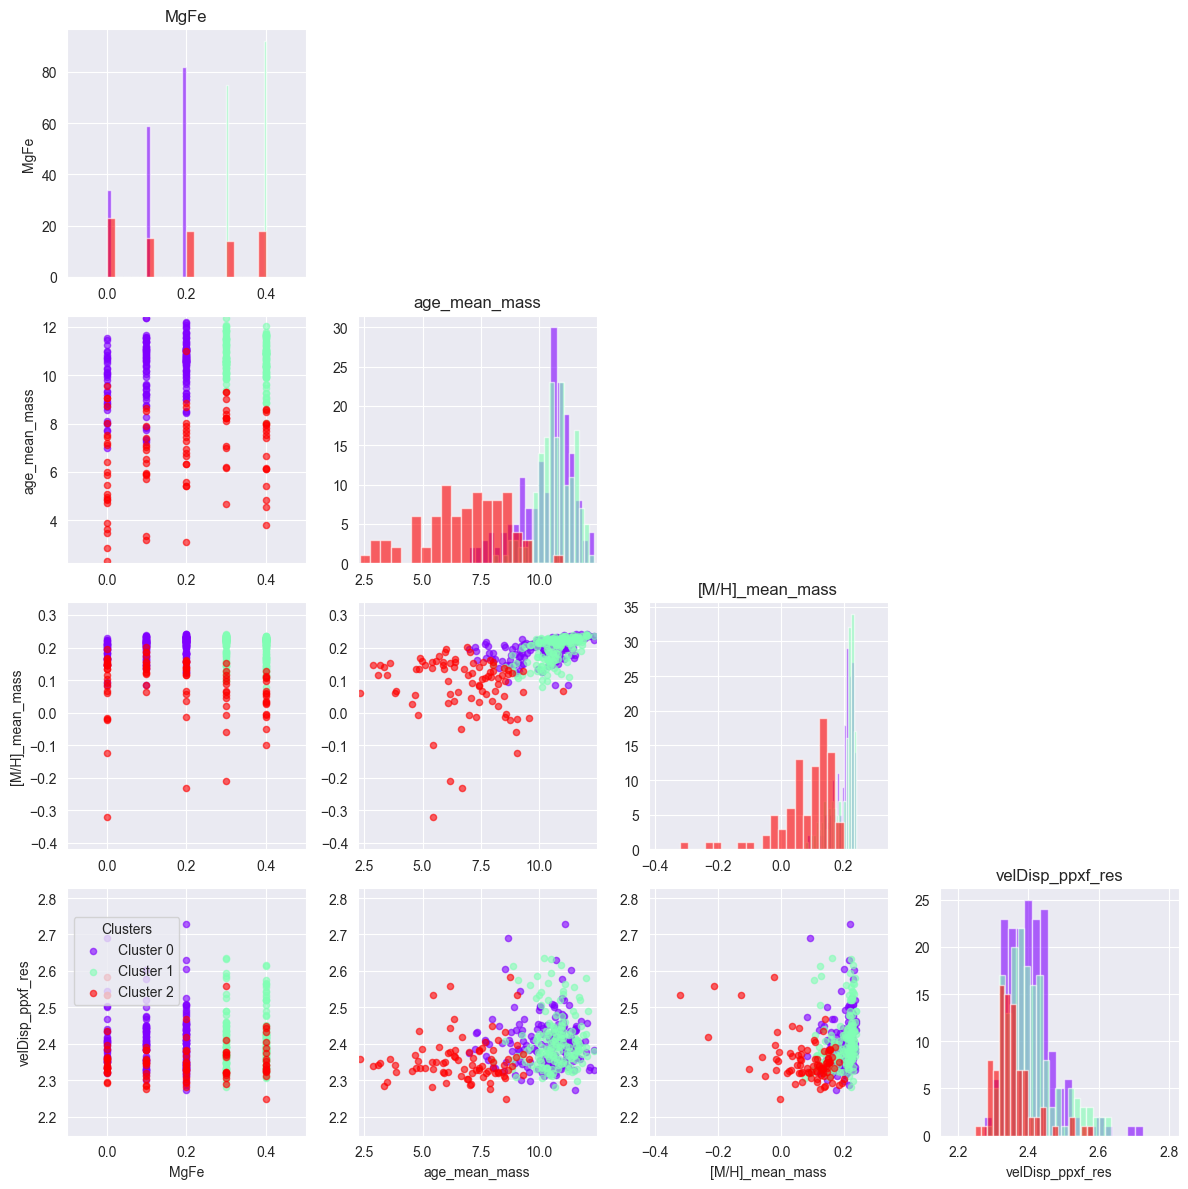

METHOD: GMM


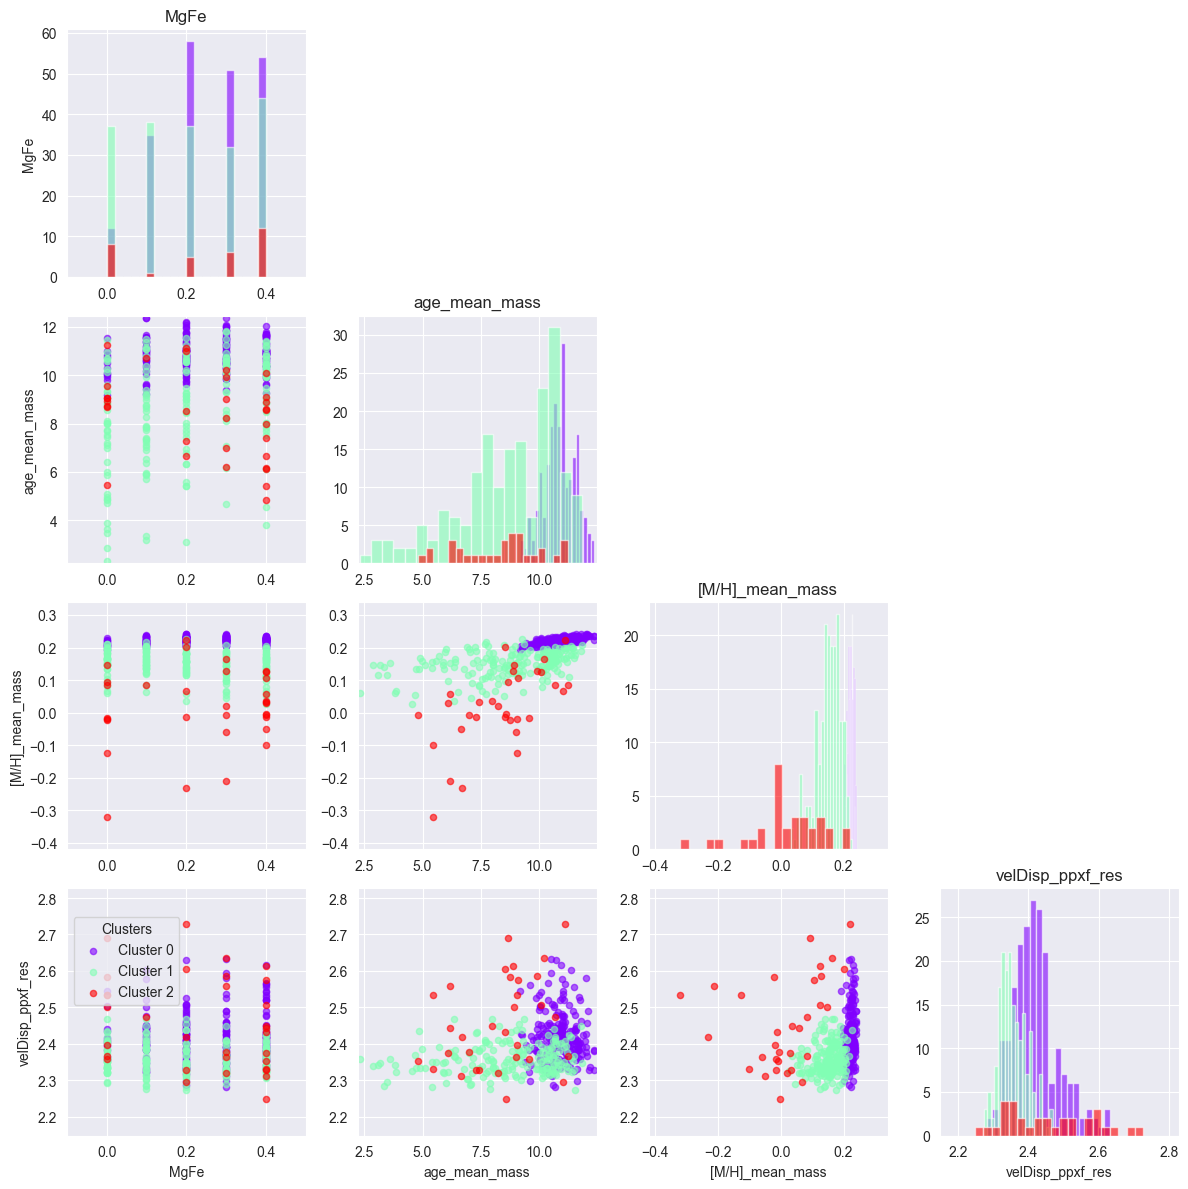

METHOD: Hierarchical


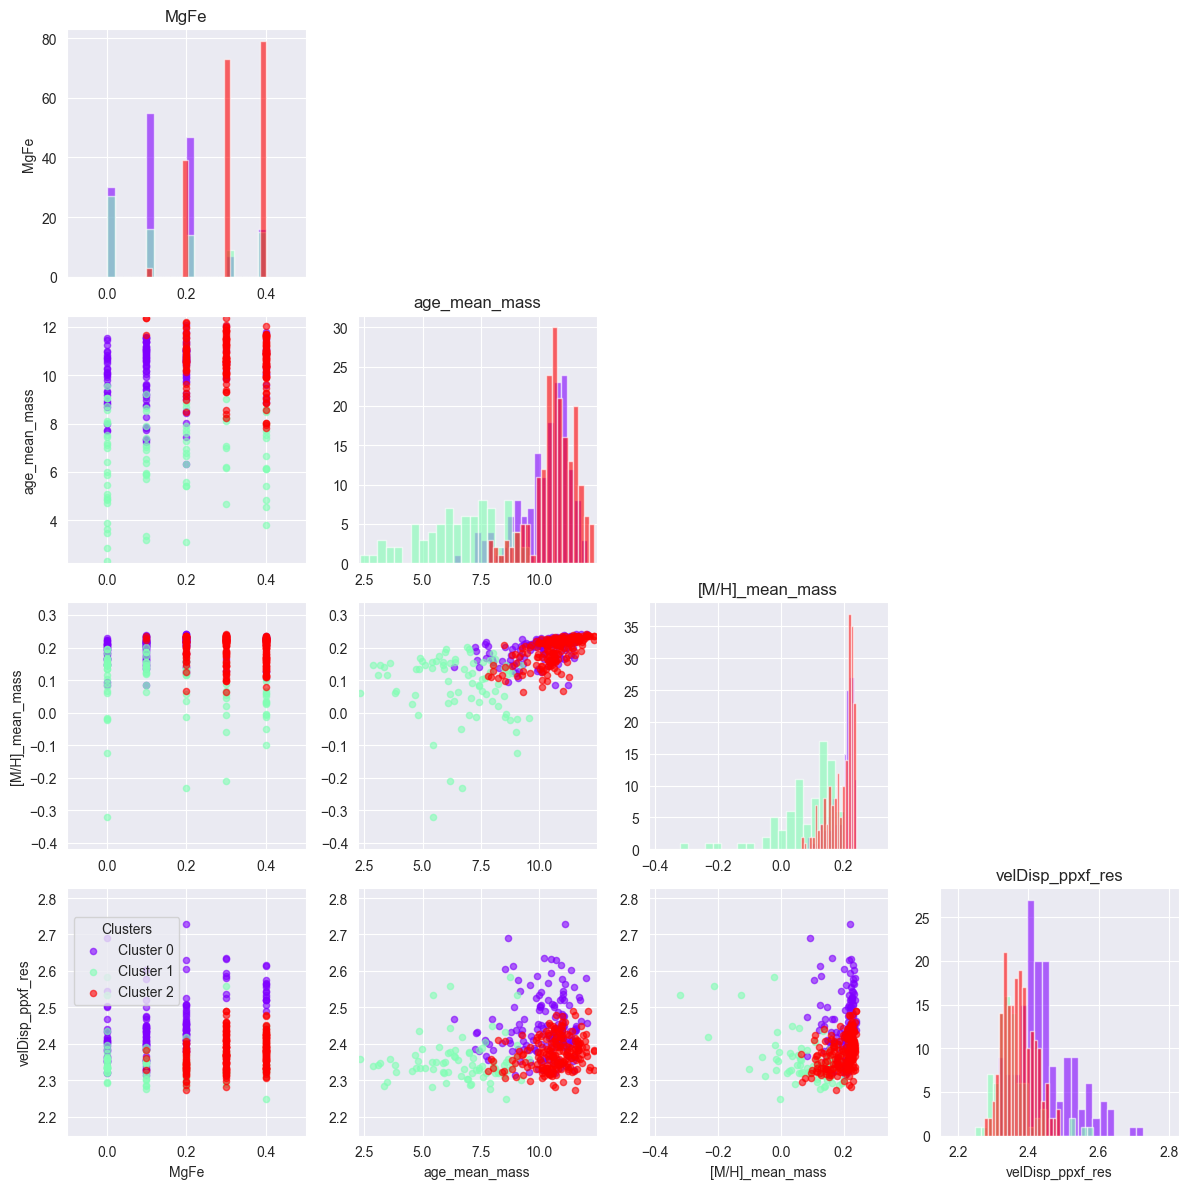

In [111]:
####################### BLOCK 7: UNWEIGHTED Version #######################

n_clusters_kmeans = 3
n_clusters_gmm=3
n_clusters_hier = 3

kmeans_model, kmeans_labels = kmeans_clustering(df, selected_features, n_clusters=n_clusters_kmeans)

gmm_model, gmm_labels = gmm_clustering(df, selected_features, n_components=n_clusters_gmm)

hc_model, hc_labels = hierarchical_clustering(df, selected_features, n_clusters=n_clusters_hier)
# Z = plot_dendrogram(df, selected_features)

methods = {
   "K-Means": kmeans_labels,
   "GMM": gmm_labels,
   "Hierarchical": hc_labels,   
}

for method_name, labels in methods.items():
    print("METHOD:", method_name)
    fig = make_corner_plot(df, labels, plot_features, method_name)
    plt.show()


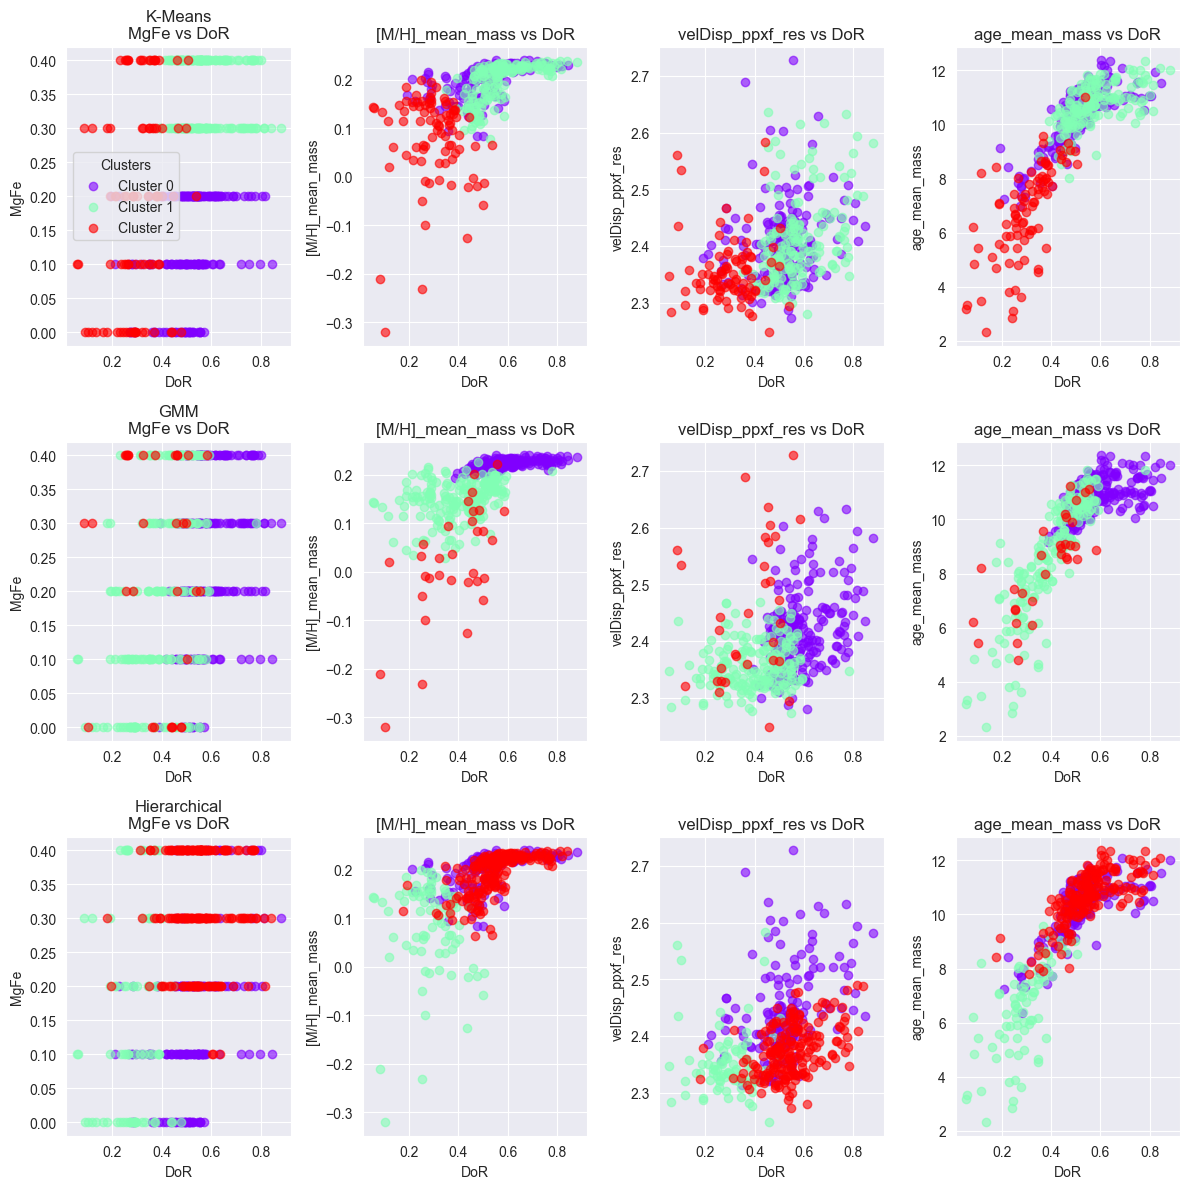

In [112]:
features = selected_features #['velDisp_ppxf_res', '[M/H]_mean_mass']
fig = plot_multi_method_features(df, methods, features, figsize=(12, 12))
plt.show()

In [113]:
export_clustering_results(df, methods)


Relabeling K-Means clusters:

Original Cluster 0:
Mean DoR: 0.514
Mean MgFe: 0.127
Size: 175

Original Cluster 1:
Mean DoR: 0.572
Mean MgFe: 0.355
Size: 167

Original Cluster 2:
Mean DoR: 0.299
Mean MgFe: 0.188
Size: 88

Cluster Mapping:
Old cluster 1 → New cluster 0
Old cluster 0 → New cluster 1
Old cluster 2 → New cluster 2
Made files

Relabeling GMM clusters:

Original Cluster 0:
Mean DoR: 0.592
Mean MgFe: 0.248
Size: 210

Original Cluster 1:
Mean DoR: 0.401
Mean MgFe: 0.204
Size: 188

Original Cluster 2:
Mean DoR: 0.379
Mean MgFe: 0.241
Size: 32

Cluster Mapping:
Old cluster 0 → New cluster 0
Old cluster 1 → New cluster 1
Old cluster 2 → New cluster 2
Made files

Relabeling Hierarchical clusters:

Original Cluster 0:
Mean DoR: 0.526
Mean MgFe: 0.151
Size: 155

Original Cluster 1:
Mean DoR: 0.291
Mean MgFe: 0.162
Size: 81

Original Cluster 2:
Mean DoR: 0.549
Mean MgFe: 0.318
Size: 194

Cluster Mapping:
Old cluster 2 → New cluster 0
Old cluster 0 → New cluster 1
Old cluster 1 → New 

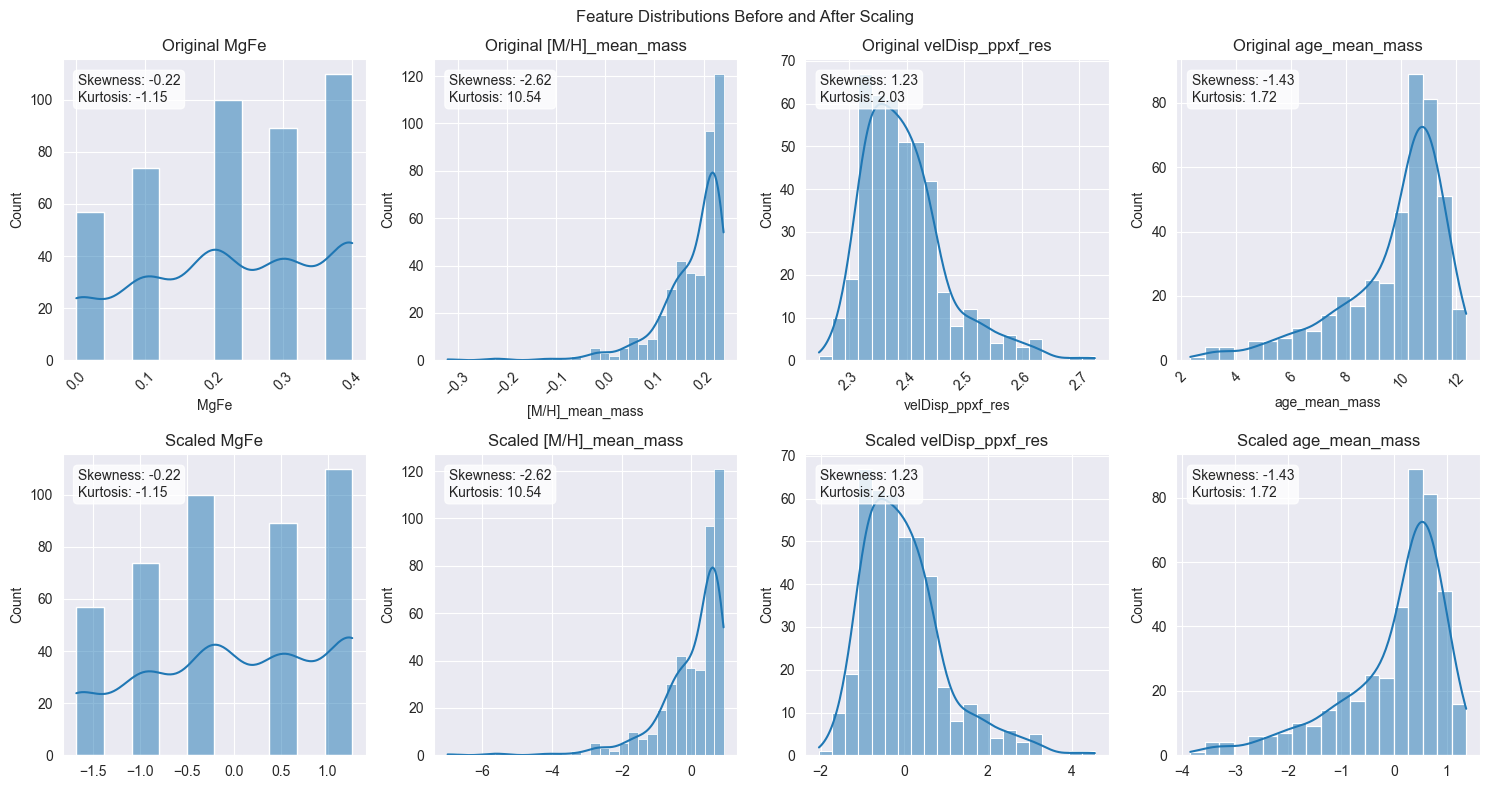


Detailed Statistics:

MgFe:
count    430.000000
mean       0.228140
std        0.136297
min        0.000000
25%        0.100000
50%        0.200000
75%        0.400000
max        0.400000
Name: MgFe, dtype: float64
Normality test p-value: 2.11e-43
IQR: 0.30
Outliers: 0 points

[M/H]_mean_mass:
count    430.000000
mean       0.175197
std        0.070894
min       -0.320058
25%        0.147387
50%        0.202895
75%        0.222209
max        0.240380
Name: [M/H]_mean_mass, dtype: float64
Normality test p-value: 3.09e-59
IQR: 0.07
Outliers: 20 points

velDisp_ppxf_res:
count    430.000000
mean       2.396133
std        0.072766
min        2.247814
25%        2.343389
50%        2.383748
75%        2.430715
max        2.727457
Name: velDisp_ppxf_res, dtype: float64
Normality test p-value: 1.74e-21
IQR: 0.09
Outliers: 18 points

age_mean_mass:
count    430.000000
mean       9.735083
std        1.927279
min        2.327166
25%        8.899622
50%       10.439134
75%       11.000728
max   

In [114]:
####################### BLOCK 8: DISTRIBUTION ANALYSIS #######################
def analyze_distributions(data, selected_features):
    n_features = len(selected_features)
    fig, axes = plt.subplots(2, n_features, figsize=(15, 8))
    fig.suptitle('Feature Distributions Before and After Scaling')

    X, feature_names = prepare_data(data, selected_features)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Plot histograms and QQ plots for each feature
    for i, feature in enumerate(selected_features):
        # Original data
        sns.histplot(data[feature], kde=True, ax=axes[0, i])
        axes[0, i].set_title(f'Original {feature}')
        axes[0, i].tick_params(axis='x', rotation=45)

        # Add skewness and kurtosis
        skew = stats.skew(data[feature].dropna())
        kurt = stats.kurtosis(data[feature].dropna())
        axes[0, i].text(0.05, 0.95, f'Skewness: {skew:.2f}\nKurtosis: {kurt:.2f}',
                        transform=axes[0, i].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        sns.histplot(X_scaled[:, i], kde=True, ax=axes[1, i])
        axes[1, i].set_title(f'Scaled {feature}')

        skew_scaled = stats.skew(X_scaled[:, i])
        kurt_scaled = stats.kurtosis(X_scaled[:, i])
        axes[1, i].text(0.05, 0.95, f'Skewness: {skew_scaled:.2f}\nKurtosis: {kurt_scaled:.2f}',
                        transform=axes[1, i].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig


import seaborn as sns
from scipy import stats

# Run the analysis
fig = analyze_distributions(df, selected_features)
plt.show()

print("\nDetailed Statistics:")
for feature in selected_features:
    print(f"\n{feature}:")
    print(df[feature].describe())

    stat, p_value = stats.normaltest(df[feature].dropna())
    print(f"Normality test p-value: {p_value:.2e}")

    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    print(f"IQR: {iqr:.2f}")
    print(f"Outliers: {sum((df[feature] < (q1 - 1.5 * iqr)) | (df[feature] > (q3 + 1.5 * iqr)))} points")


DoR Group sizes and means:
DoR < 0.3: 56 galaxies, mean DoR = 0.229
0.3 ≤ DoR < 0.6: 293 galaxies, mean DoR = 0.486
DoR ≥ 0.6: 81 galaxies, mean DoR = 0.699


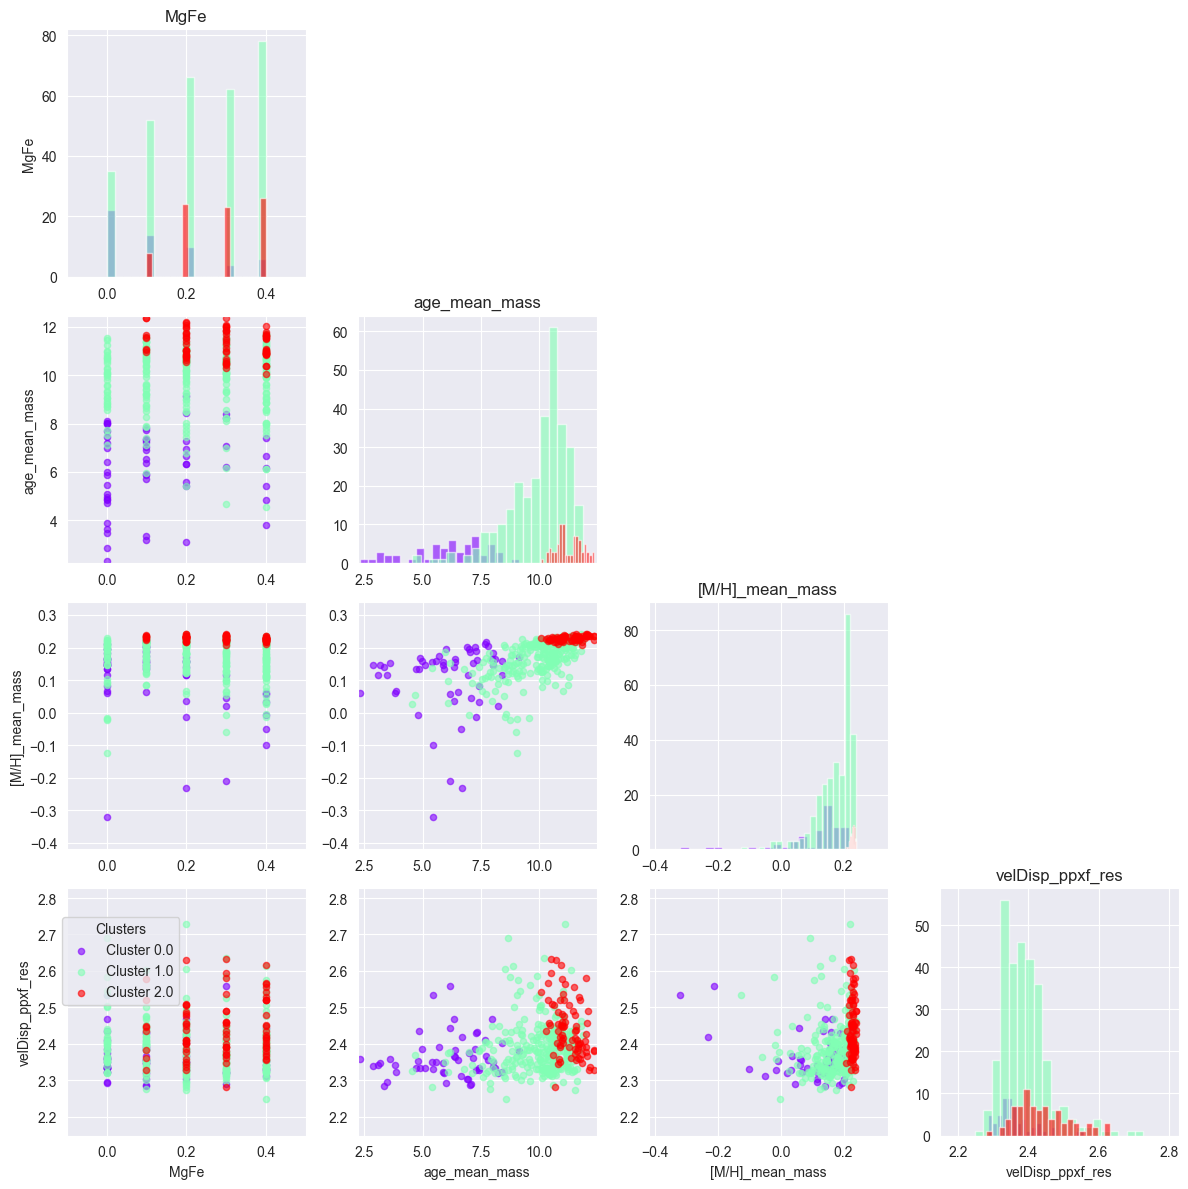

In [115]:
dor_labels = np.zeros(len(df))
dor_labels[(df['DoR'] >= 0.3) & (df['DoR'] < 0.6)] = 1
dor_labels[df['DoR'] >= 0.6] = 2

print("\nDoR Group sizes and means:")
for i, name in enumerate(['DoR < 0.3', '0.3 ≤ DoR < 0.6', 'DoR ≥ 0.6']):
    mask = dor_labels == i
    print(f"{name}: {np.sum(mask)} galaxies, mean DoR = {df['DoR'][mask].mean():.3f}")

fig = make_corner_plot(df, dor_labels, plot_features, 'DoR Groups')
plt.show()